# Kernel Regression: Visual Examples

This notebook demonstrates the main features of the `kernel-regression` package with visual examples.

## Table of Contents
1. [Basic Nadaraya-Watson Regression](#1-basic-nadaraya-watson-regression)
2. [Local Polynomial Regression](#2-local-polynomial-regression)
3. [Boundary Bias Comparison](#3-boundary-bias-comparison)
4. [Bandwidth Selection](#4-bandwidth-selection)
5. [Per-Dimension Bandwidth (Variable Selection)](#5-per-dimension-bandwidth-variable-selection)
6. [Heteroscedasticity Detection](#6-heteroscedasticity-detection)
7. [Confidence Intervals](#7-confidence-intervals)
8. [Goodness of Fit Diagnostics](#8-goodness-of-fit-diagnostics)
9. [2D Regression Visualization](#9-2d-regression-visualization)

In [11]:
# Ensure plots render inline in notebooks
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# Import kernel regression package
from kernel_regression import (
    NadarayaWatson,
    LocalPolynomialRegression,
    CrossValidatedBandwidth,
    GoodnessOfFit,
    heteroscedasticity_test,
    wild_bootstrap_confidence_intervals,
    fan_yao_variance_estimation,
)

print("✓ Imports successful!")

✓ Imports successful!


## 1. Basic Nadaraya-Watson Regression

Nadaraya-Watson (local constant) kernel regression is the simplest form of kernel regression. It computes weighted averages of nearby points using a kernel function.

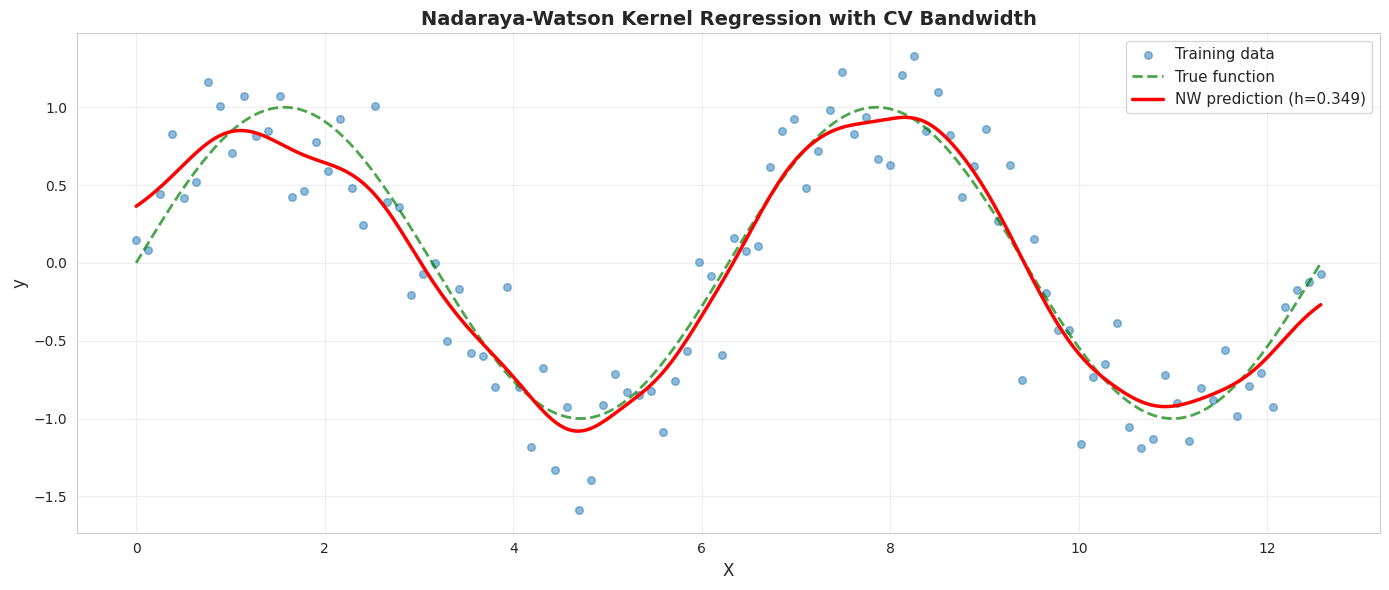

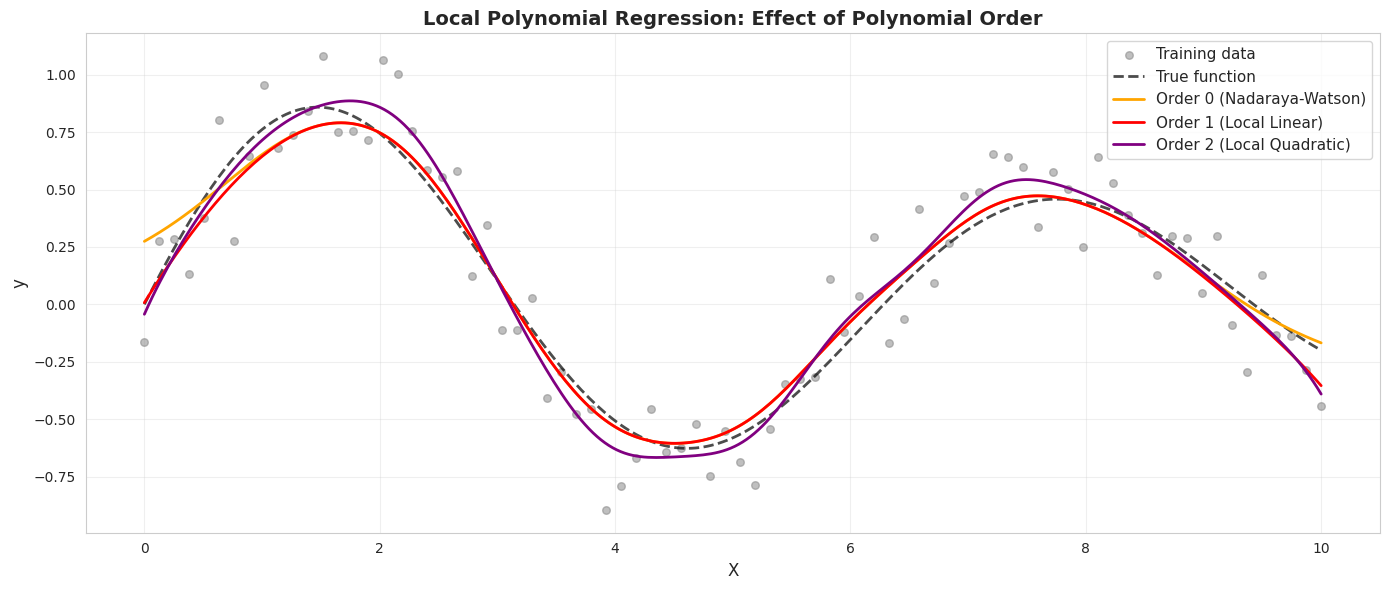

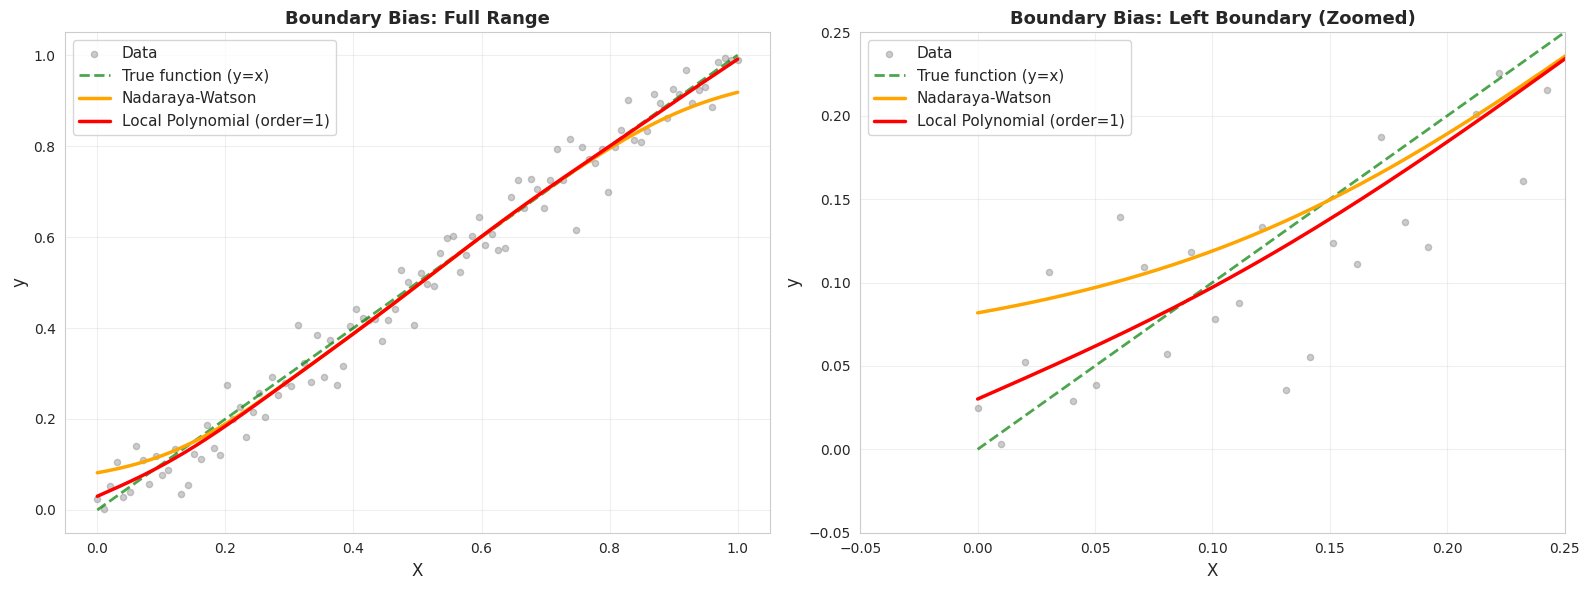

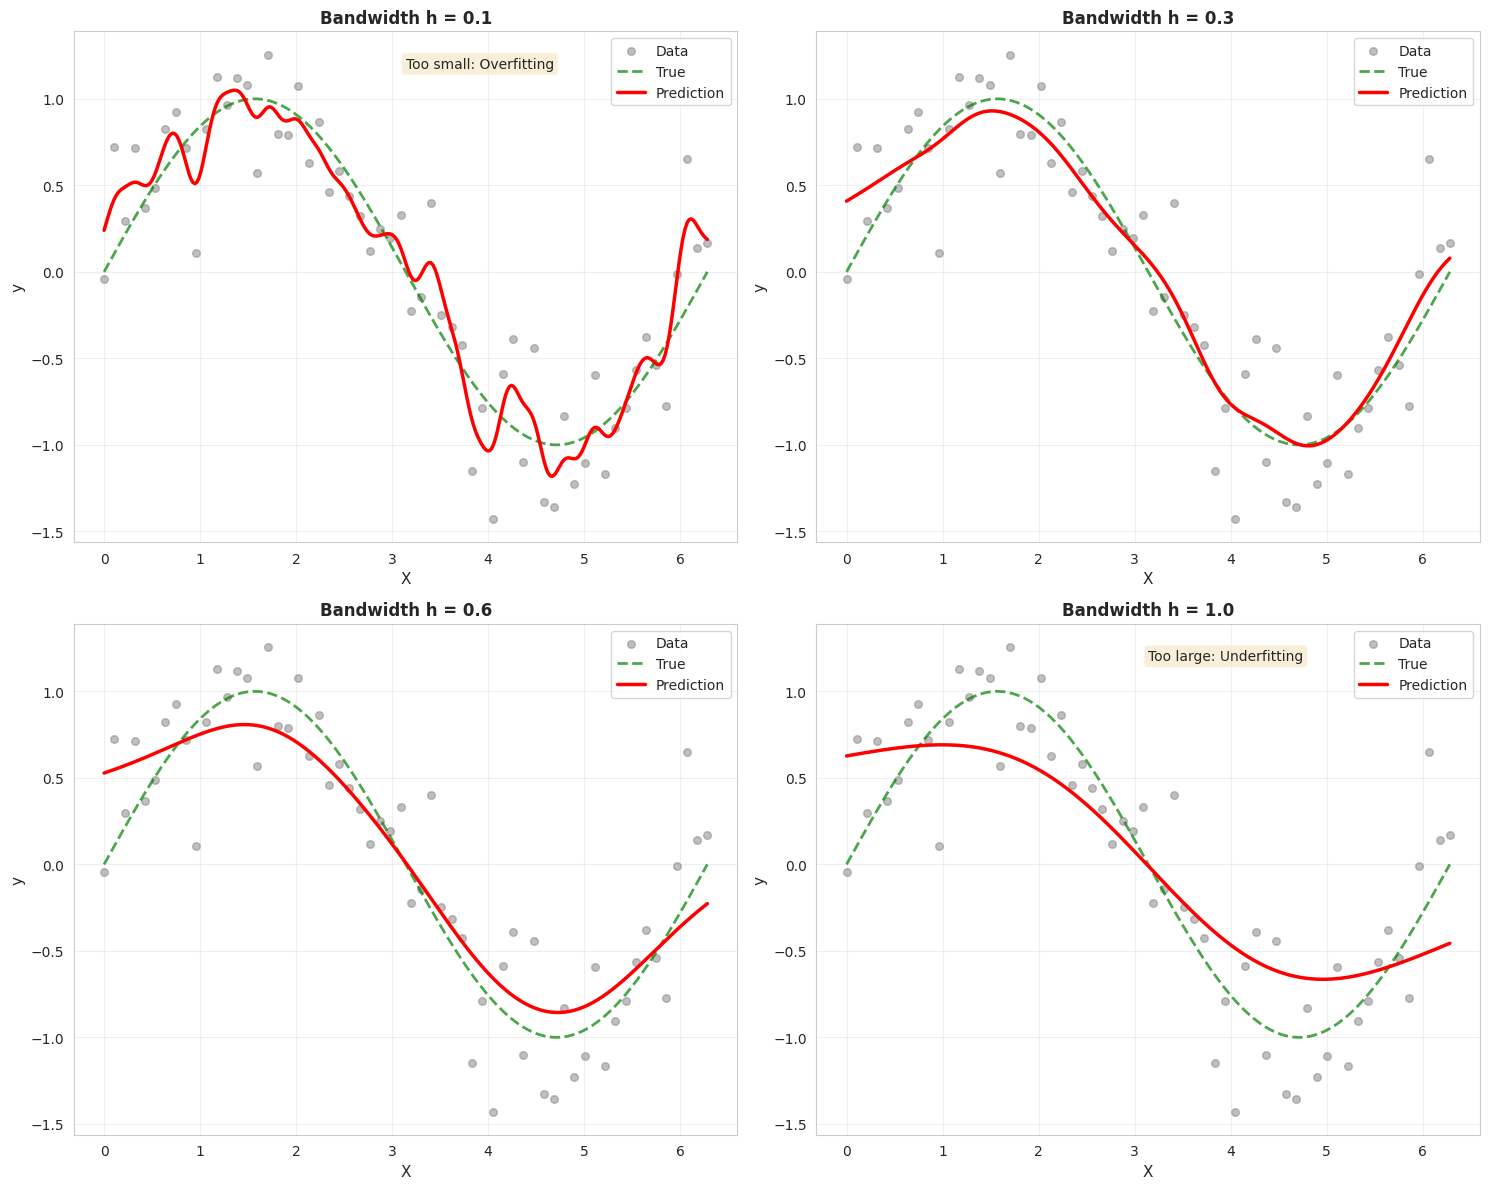

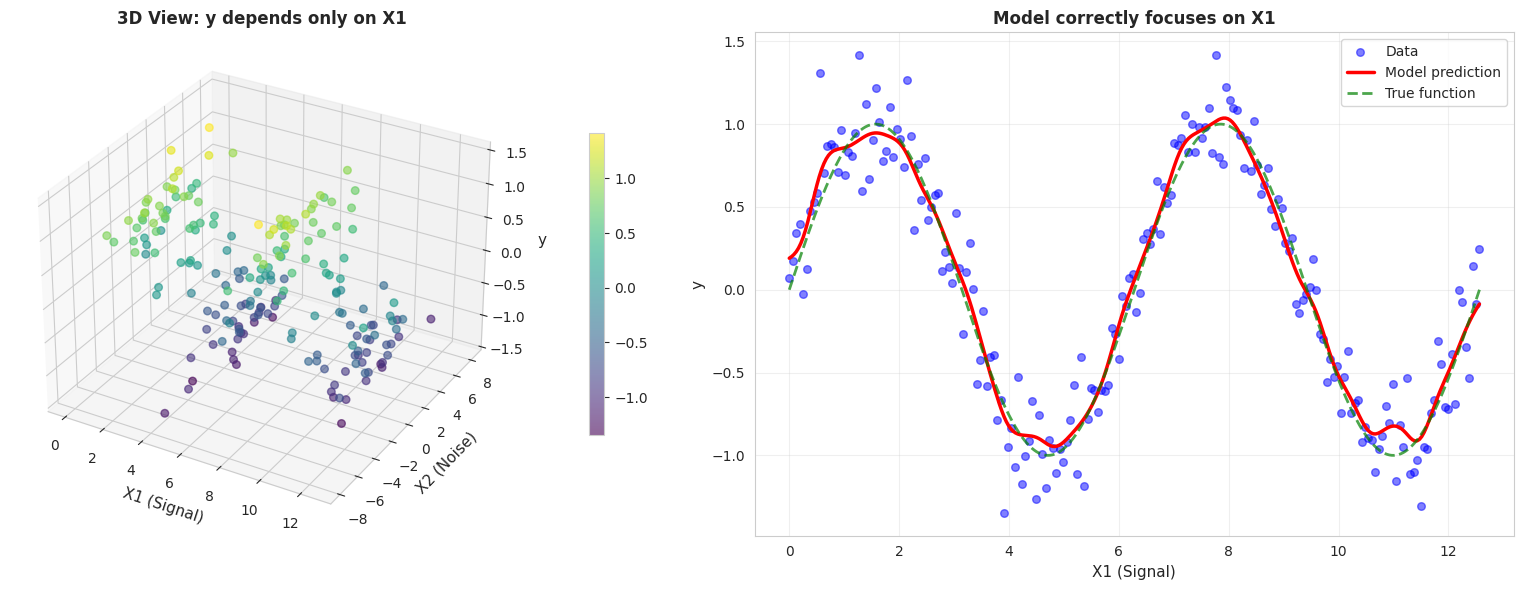

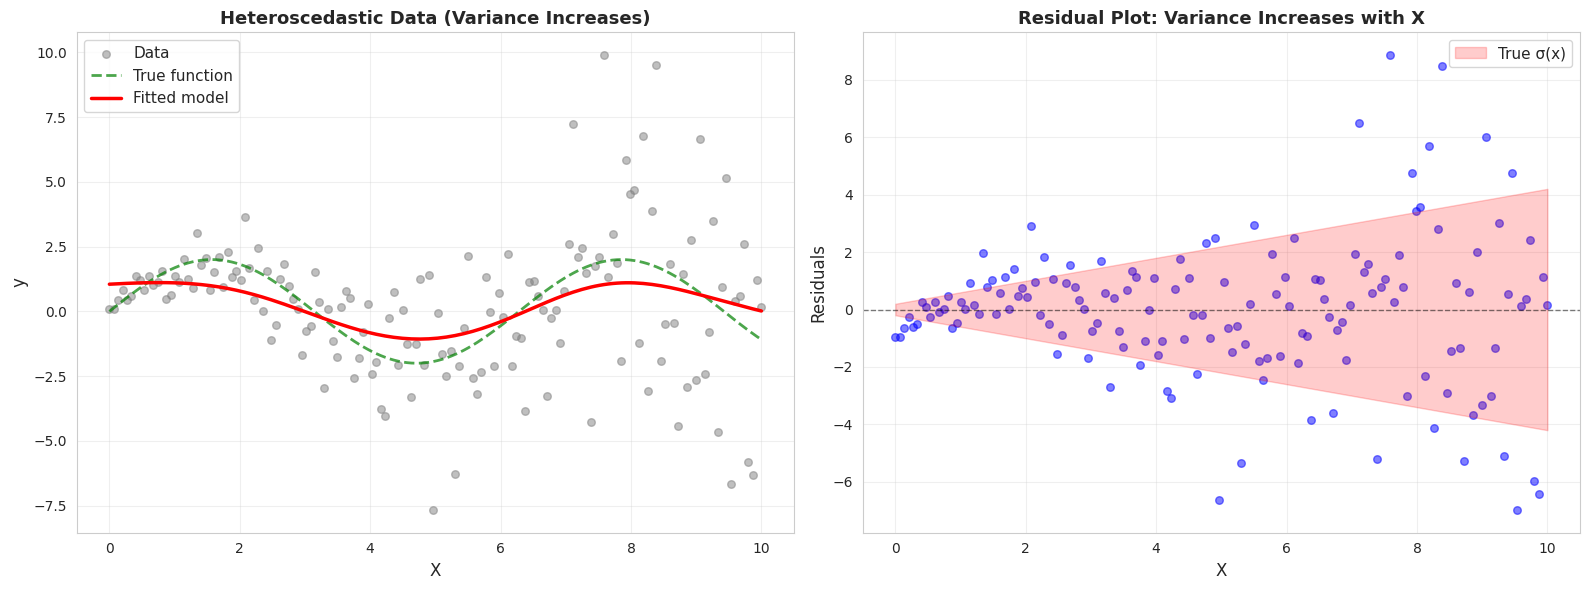

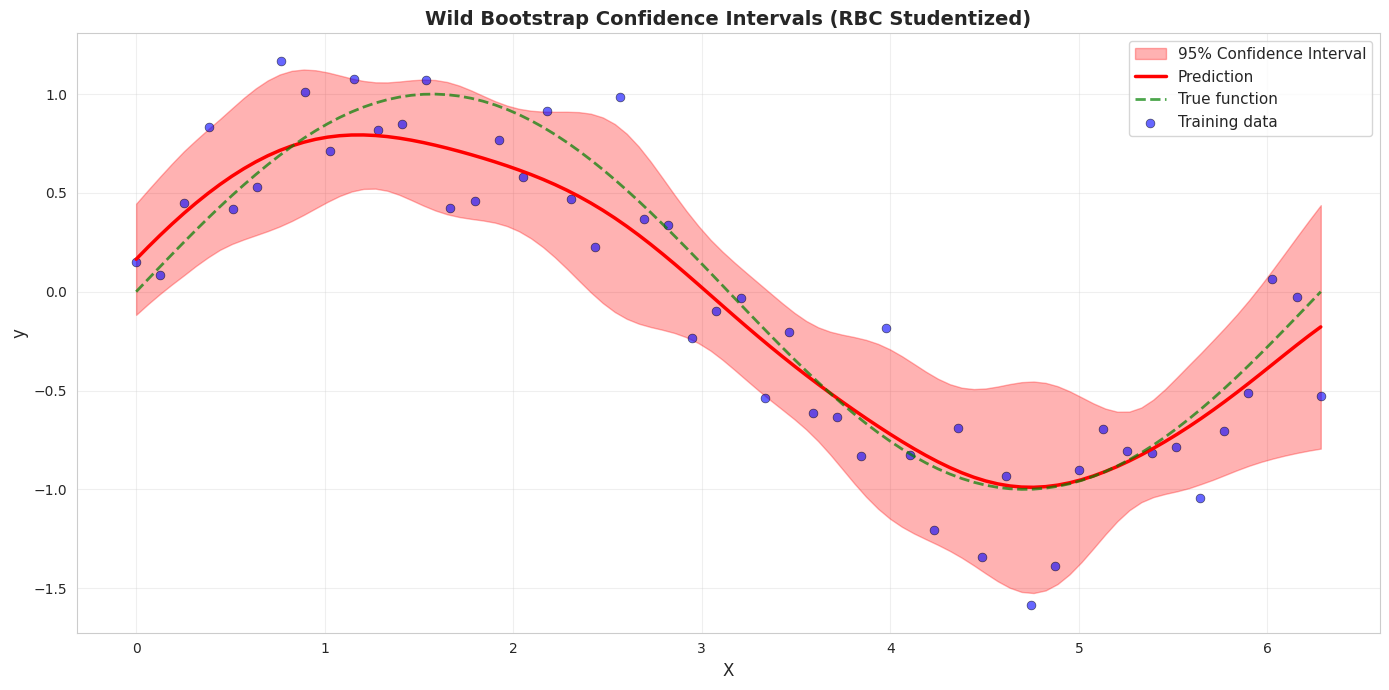

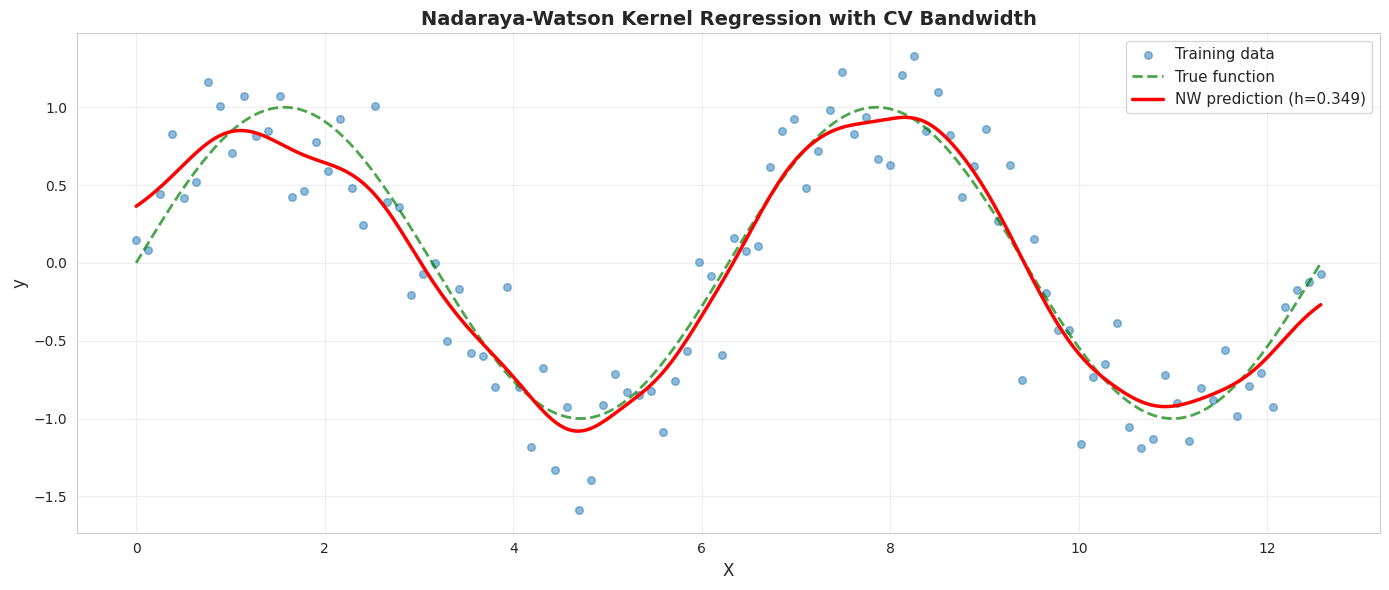

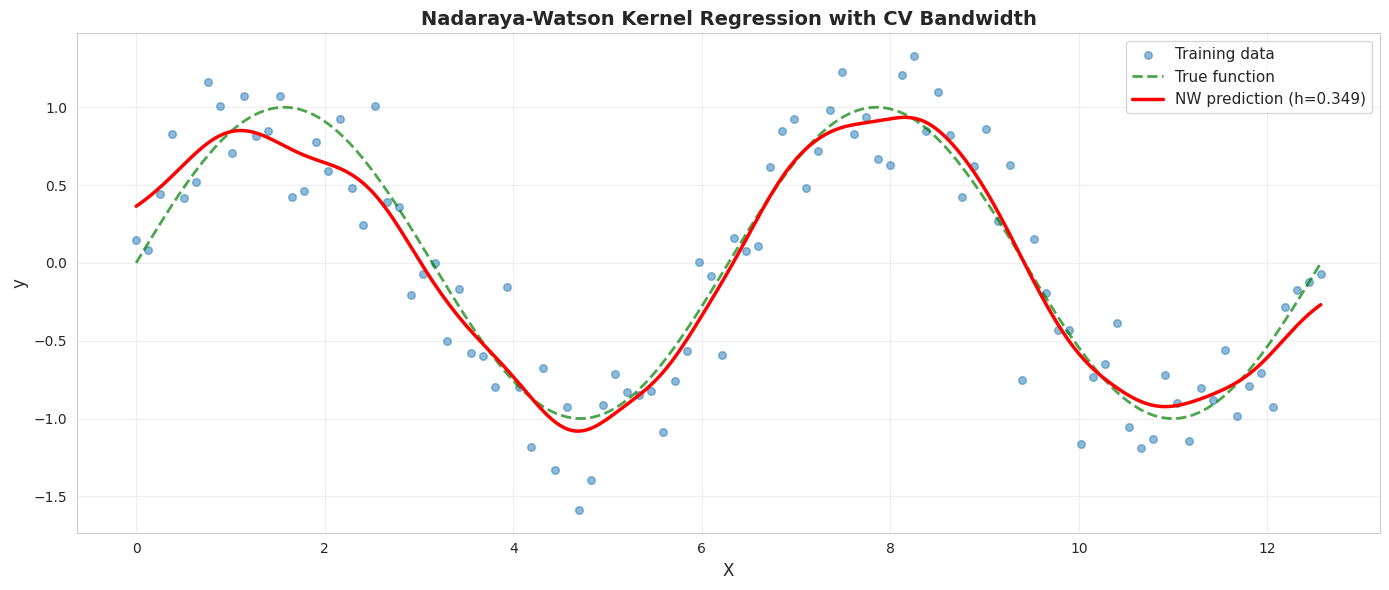

In [12]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 4*np.pi, 100).reshape(-1, 1)
y_true = np.sin(X.ravel())
y = y_true + 0.3 * np.random.randn(100)

# Fit Nadaraya-Watson with automatic bandwidth selection
model = NadarayaWatson(bandwidth="cv").fit(X, y)

# Predict on fine grid
X_plot = np.linspace(0, 4*np.pi, 300).reshape(-1, 1)
y_pred = model.predict(X_plot)

# Plot
plt.figure(figsize=(14, 6))
plt.scatter(X, y, alpha=0.5, s=30, label='Training data')
plt.plot(X_plot, np.sin(X_plot.ravel()), 'g--', linewidth=2, label='True function', alpha=0.7)
plt.plot(X_plot, y_pred, 'r-', linewidth=2.5, label=f'NW prediction (h={model.bandwidth_[0]:.3f})')
plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Nadaraya-Watson Kernel Regression with CV Bandwidth', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# print(f"Selected bandwidth: {model.bandwidth_[0]:.4f}")

## 2. Local Polynomial Regression

Local polynomial regression fits a polynomial at each point using weighted least squares. Higher-order polynomials can capture more complex local patterns.

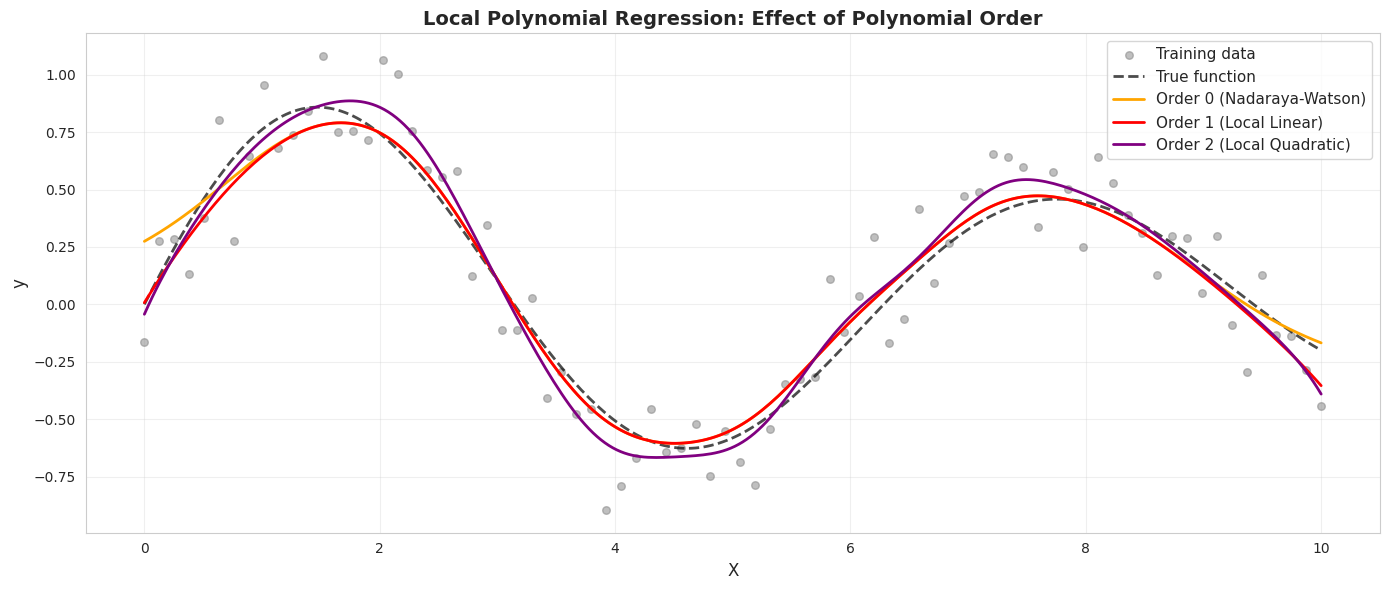

In [13]:
# Generate data with more complex pattern
np.random.seed(123)
X = np.linspace(0, 10, 80).reshape(-1, 1)
y_true = np.sin(X.ravel()) * np.exp(-X.ravel()/10)
y = y_true + 0.15 * np.random.randn(80)

# Fit models with different polynomial orders
orders = [0, 1, 2]
models = {}
for order in orders:
    if order == 0:
        # Order 0 is Nadaraya-Watson
        models[order] = NadarayaWatson(bandwidth=0.5).fit(X, y)
    else:
        models[order] = LocalPolynomialRegression(order=order, bandwidth=0.5).fit(X, y)

# Predict
X_plot = np.linspace(0, 10, 300).reshape(-1, 1)
y_plot_true = np.sin(X_plot.ravel()) * np.exp(-X_plot.ravel()/10)

# Plot comparison
plt.figure(figsize=(14, 6))
plt.scatter(X, y, alpha=0.5, s=30, c='gray', label='Training data')
plt.plot(X_plot, y_plot_true, 'k--', linewidth=2, label='True function', alpha=0.7)

colors = ['orange', 'red', 'purple']
labels = ['Order 0 (Nadaraya-Watson)', 'Order 1 (Local Linear)', 'Order 2 (Local Quadratic)']
for i, order in enumerate(orders):
    y_pred = models[order].predict(X_plot)
    plt.plot(X_plot, y_pred, color=colors[i], linewidth=2, label=labels[i])

plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Local Polynomial Regression: Effect of Polynomial Order', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Boundary Bias Comparison

Nadaraya-Watson suffers from boundary bias because it can only average points on one side near boundaries. Local polynomial regression (especially local linear) eliminates this bias.

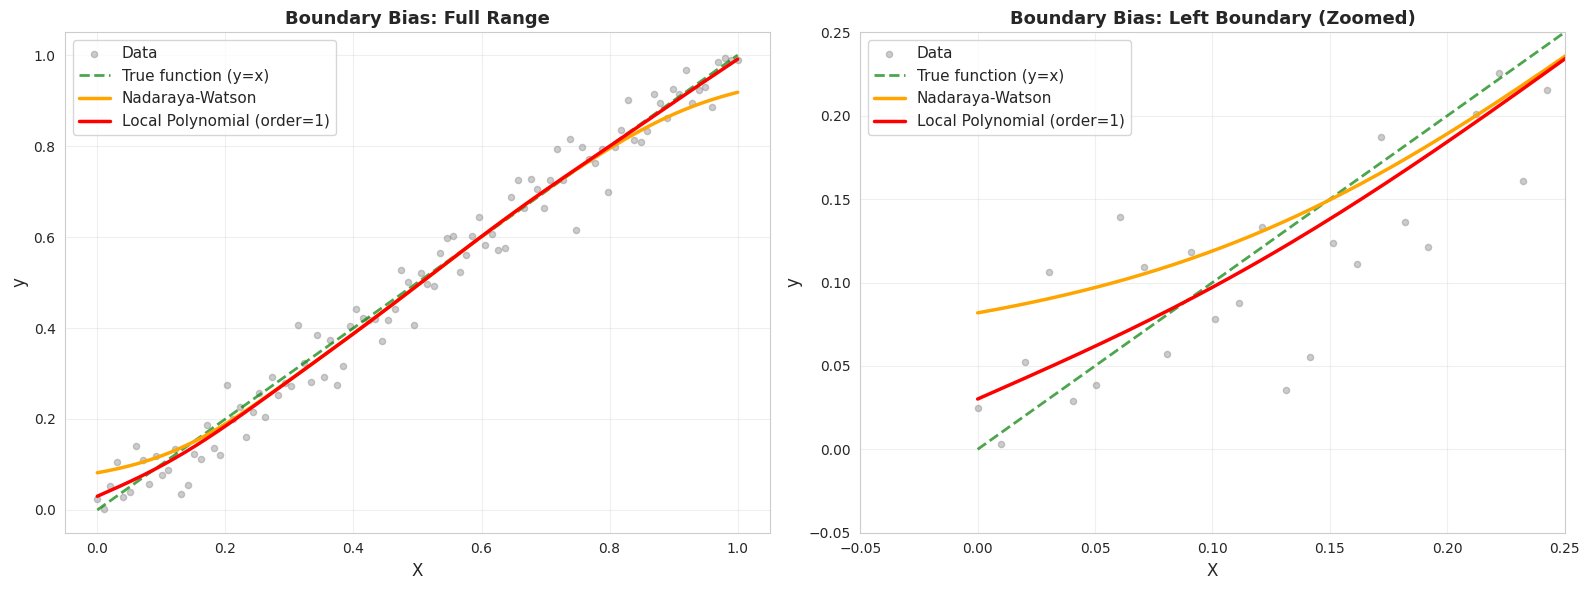


Boundary Predictions:
At x=0.0: True=0.0000, NW=0.0818 (bias=0.0818), LP=0.0302 (bias=0.0302)
At x=1.0: True=1.0000, NW=0.9182 (bias=0.0818), LP=0.9910 (bias=0.0090)


In [14]:
# Generate data on bounded interval
np.random.seed(42)
X = np.linspace(0, 1, 100).reshape(-1, 1)
y = X.ravel()  # True function: y = x
y_noisy = y + 0.05 * np.random.randn(100)

# Fit both models
nw_model = NadarayaWatson(bandwidth=0.1).fit(X, y_noisy)
lp_model = LocalPolynomialRegression(order=1, bandwidth=0.1).fit(X, y_noisy)

# Predict across the range
X_plot = np.linspace(0, 1, 300).reshape(-1, 1)
nw_pred = nw_model.predict(X_plot)
lp_pred = lp_model.predict(X_plot)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full range
axes[0].scatter(X, y_noisy, alpha=0.4, s=20, c='gray', label='Data')
axes[0].plot(X_plot, X_plot.ravel(), 'g--', linewidth=2, label='True function (y=x)', alpha=0.7)
axes[0].plot(X_plot, nw_pred, 'orange', linewidth=2.5, label='Nadaraya-Watson')
axes[0].plot(X_plot, lp_pred, 'red', linewidth=2.5, label='Local Polynomial (order=1)')
axes[0].set_xlabel('X', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title('Boundary Bias: Full Range', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Zoom on boundaries
axes[1].scatter(X, y_noisy, alpha=0.4, s=20, c='gray', label='Data')
axes[1].plot(X_plot, X_plot.ravel(), 'g--', linewidth=2, label='True function (y=x)', alpha=0.7)
axes[1].plot(X_plot, nw_pred, 'orange', linewidth=2.5, label='Nadaraya-Watson')
axes[1].plot(X_plot, lp_pred, 'red', linewidth=2.5, label='Local Polynomial (order=1)')
axes[1].set_xlim([-0.05, 0.25])
axes[1].set_ylim([-0.05, 0.25])
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('Boundary Bias: Left Boundary (Zoomed)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compute boundary bias
boundary_x = np.array([[0.0], [1.0]])
nw_boundary = nw_model.predict(boundary_x)
lp_boundary = lp_model.predict(boundary_x)
true_boundary = boundary_x.ravel()

print("\nBoundary Predictions:")
print(f"At x=0.0: True={true_boundary[0]:.4f}, NW={nw_boundary[0]:.4f} (bias={abs(nw_boundary[0]-true_boundary[0]):.4f}), LP={lp_boundary[0]:.4f} (bias={abs(lp_boundary[0]-true_boundary[0]):.4f})")
print(f"At x=1.0: True={true_boundary[1]:.4f}, NW={nw_boundary[1]:.4f} (bias={abs(nw_boundary[1]-true_boundary[1]):.4f}), LP={lp_boundary[1]:.4f} (bias={abs(lp_boundary[1]-true_boundary[1]):.4f})")

## 4. Bandwidth Selection

The bandwidth parameter controls the trade-off between bias and variance. Too small causes overfitting (high variance), too large causes underfitting (high bias). Cross-validation finds the optimal bandwidth.

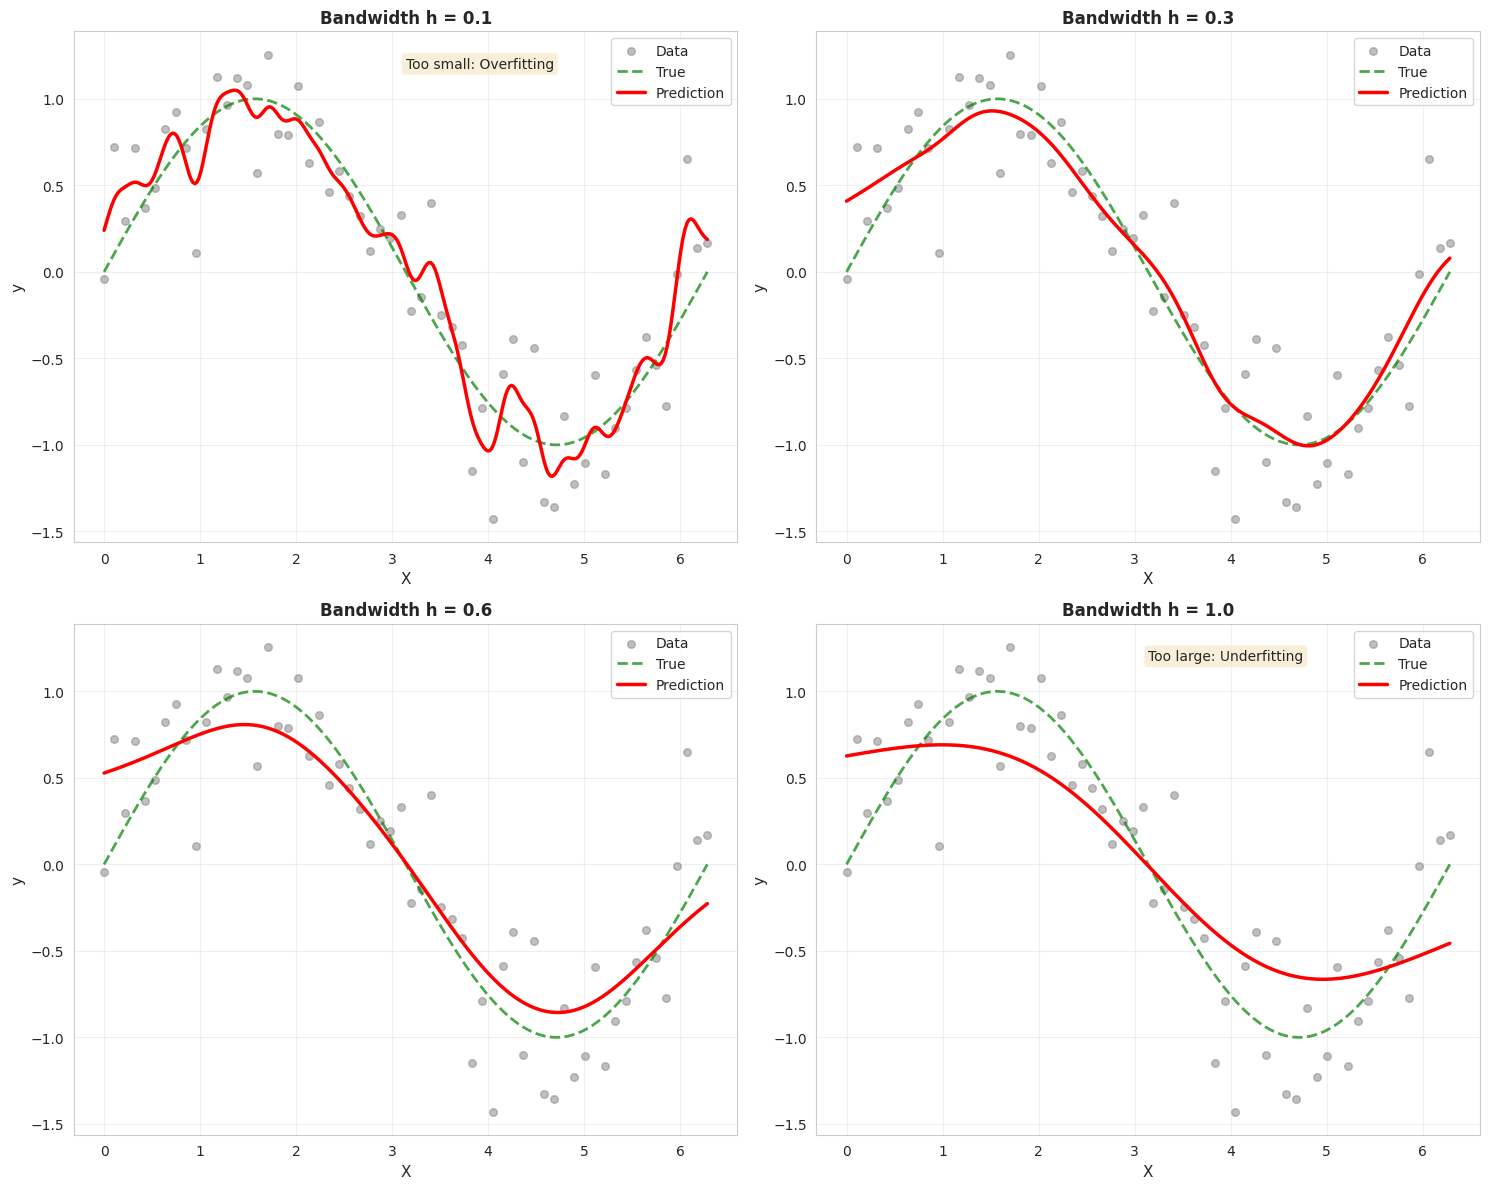


Using Cross-Validation to select optimal bandwidth...
Optimal bandwidth: 0.2927


In [15]:
# Generate data
np.random.seed(99)
X = np.linspace(0, 2*np.pi, 60).reshape(-1, 1)
y_true = np.sin(X.ravel())
y = y_true + 0.3 * np.random.randn(60)

# Try different bandwidths
bandwidths = [0.1, 0.3, 0.6, 1.0]
X_plot = np.linspace(0, 2*np.pi, 300).reshape(-1, 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, h in enumerate(bandwidths):
    model = NadarayaWatson(bandwidth=h).fit(X, y)
    y_pred = model.predict(X_plot)
    
    axes[i].scatter(X, y, alpha=0.5, s=30, c='gray', label='Data')
    axes[i].plot(X_plot, np.sin(X_plot.ravel()), 'g--', linewidth=2, label='True', alpha=0.7)
    axes[i].plot(X_plot, y_pred, 'r-', linewidth=2.5, label=f'Prediction')
    axes[i].set_xlabel('X', fontsize=11)
    axes[i].set_ylabel('y', fontsize=11)
    axes[i].set_title(f'Bandwidth h = {h}', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=10)
    axes[i].grid(alpha=0.3)
    
    # Add annotation
    if i == 0:
        axes[i].text(0.5, 0.95, 'Too small: Overfitting', transform=axes[i].transAxes,
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    elif i == 3:
        axes[i].text(0.5, 0.95, 'Too large: Underfitting', transform=axes[i].transAxes,
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Now use cross-validation
print("\nUsing Cross-Validation to select optimal bandwidth...")
model_cv = NadarayaWatson(bandwidth="cv").fit(X, y)
print(f"Optimal bandwidth: {model_cv.bandwidth_[0]:.4f}")

## 5. Per-Dimension Bandwidth (Variable Selection)

When dealing with multivariate data, different features may need different amounts of smoothing. Per-dimension bandwidth selection can identify and smooth out irrelevant features.

Per-Dimension Bandwidth Selection:
  Signal feature (X1) bandwidth: 0.2012
  Noise feature (X2) bandwidth:  3.2867
  Ratio (noise/signal): 16.3x

✓ Large bandwidth for X2 means it gets smoothed out (automatic variable selection)


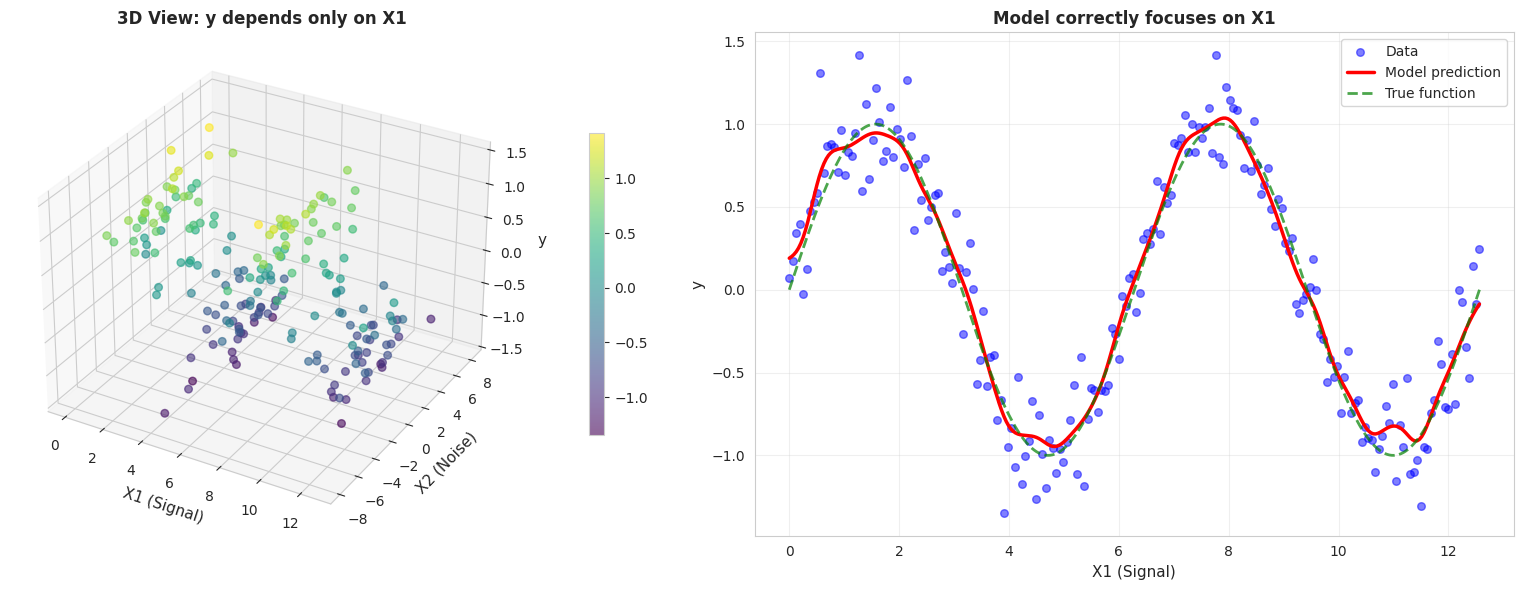

In [16]:
# Generate data: X1 is signal, X2 is noise
np.random.seed(42)
n = 200
X1 = np.linspace(0, 4*np.pi, n)  # Signal feature
X2 = np.random.randn(n) * 3      # Noise feature
X = np.column_stack([X1, X2])
y = np.sin(X1) + 0.2 * np.random.randn(n)  # Only depends on X1

# Fit with per-dimension bandwidth
selector = CrossValidatedBandwidth(cv="loo", per_dimension=True)
bandwidth = selector(X, y)

print("Per-Dimension Bandwidth Selection:")
print(f"  Signal feature (X1) bandwidth: {bandwidth[0]:.4f}")
print(f"  Noise feature (X2) bandwidth:  {bandwidth[1]:.4f}")
print(f"  Ratio (noise/signal): {bandwidth[1]/bandwidth[0]:.1f}x")
print("\n✓ Large bandwidth for X2 means it gets smoothed out (automatic variable selection)")

# Visualize the data
fig = plt.figure(figsize=(16, 6))

# 3D scatter
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(X1, X2, y, c=y, cmap='viridis', s=30, alpha=0.6)
ax1.set_xlabel('X1 (Signal)', fontsize=11)
ax1.set_ylabel('X2 (Noise)', fontsize=11)
ax1.set_zlabel('y', fontsize=11)
ax1.set_title('3D View: y depends only on X1', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax1, pad=0.1, shrink=0.6)

# 2D projection
ax2 = fig.add_subplot(122)
ax2.scatter(X1, y, alpha=0.5, s=30, c='blue', label='Data')
# Fit model and show prediction
model = NadarayaWatson(bandwidth=bandwidth).fit(X, y)
X1_plot = np.linspace(0, 4*np.pi, 300)
X2_mean = np.zeros(300)  # Use mean of X2
X_plot = np.column_stack([X1_plot, X2_mean])
y_pred = model.predict(X_plot)
ax2.plot(X1_plot, y_pred, 'r-', linewidth=2.5, label='Model prediction')
ax2.plot(X1_plot, np.sin(X1_plot), 'g--', linewidth=2, label='True function', alpha=0.7)
ax2.set_xlabel('X1 (Signal)', fontsize=11)
ax2.set_ylabel('y', fontsize=11)
ax2.set_title('Model correctly focuses on X1', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Heteroscedasticity Detection

Heteroscedasticity occurs when the variance of errors changes across the input space. This package provides multiple tests to detect it.

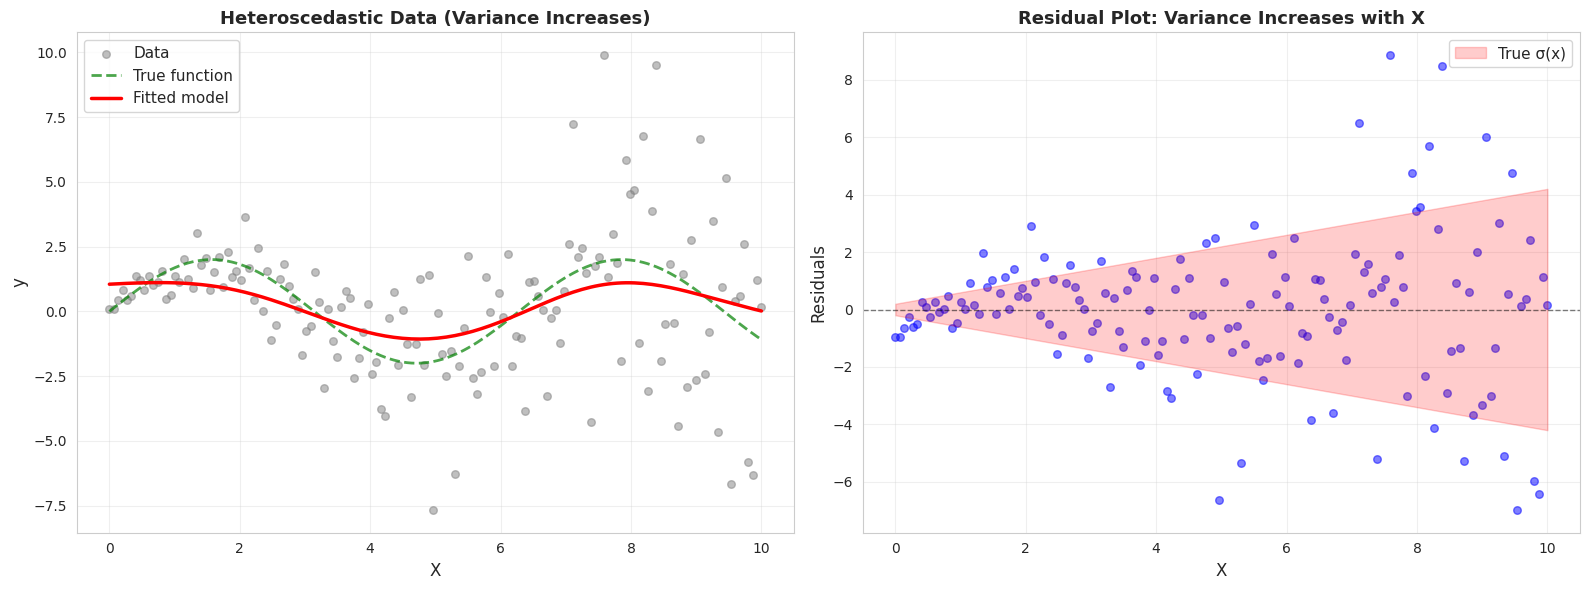


Heteroscedasticity Test Results:
white               : p-value = 0.0000 [DETECTED]
breusch_pagan       : p-value = 0.0000 [DETECTED]
dette_munk_wagner   : p-value = 0.0020 [DETECTED]


In [17]:
# Generate heteroscedastic data (variance increases with x)
np.random.seed(42)
X = np.linspace(0, 10, 150).reshape(-1, 1)
y_true = 2 * np.sin(X.ravel())
# Variance increases with x ("trumpet" pattern)
noise_std = 0.2 + 0.4 * X.ravel()
y = y_true + np.random.randn(150) * noise_std

# Fit model
model = NadarayaWatson(bandwidth="silverman").fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

# Test for heteroscedasticity
tests = ["white", "breusch_pagan", "dette_munk_wagner"]
results = {}
for test in tests:
    result = heteroscedasticity_test(model, X, y, test=test, alpha=0.05)
    results[test] = result

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Data and fit
axes[0].scatter(X, y, alpha=0.5, s=30, c='gray', label='Data')
axes[0].plot(X, y_true, 'g--', linewidth=2, label='True function', alpha=0.7)
axes[0].plot(X, y_pred, 'r-', linewidth=2.5, label='Fitted model')
axes[0].set_xlabel('X', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title('Heteroscedastic Data (Variance Increases)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Plot 2: Residuals showing increasing variance
axes[1].scatter(X, residuals, alpha=0.5, s=30, c='blue')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
# Add envelope showing standard deviation
axes[1].fill_between(X.ravel(), -noise_std, noise_std, alpha=0.2, color='red', label='True σ(x)')
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot: Variance Increases with X', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print test results
print("\nHeteroscedasticity Test Results:")
print("="*60)
for test, result in results.items():
    status = "DETECTED" if result.is_heteroscedastic else "NOT DETECTED"
    print(f"{test:20s}: p-value = {result.p_value:.4f} [{status}]")
print("="*60)

## 7. Confidence Intervals

Wild bootstrap confidence intervals provide robust uncertainty quantification, especially for heteroscedastic data.

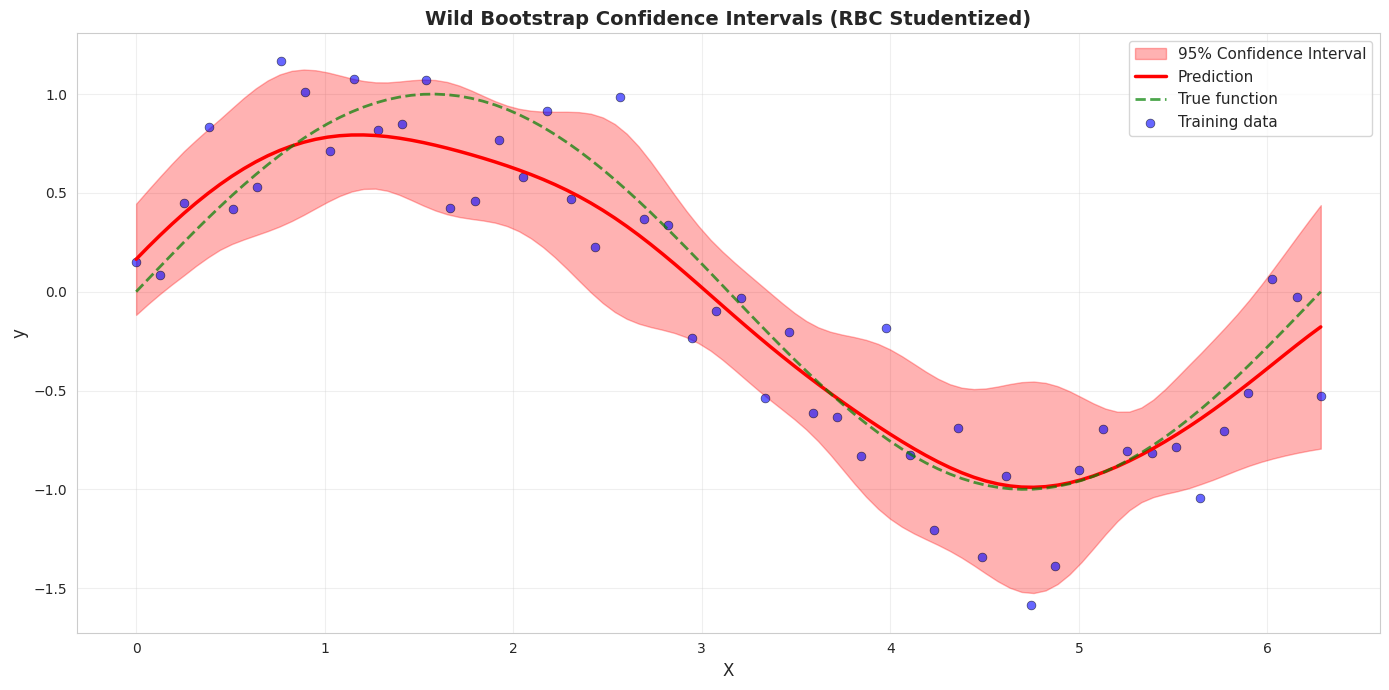

Confidence level: 95.0%


AttributeError: 'ConfidenceIntervalResult' object has no attribute 'n_bootstrap'

In [18]:
# Generate data
np.random.seed(42)
X = np.linspace(0, 2*np.pi, 50).reshape(-1, 1)
y_true = np.sin(X.ravel())
y = y_true + 0.3 * np.random.randn(50)

# Fit model
model = NadarayaWatson(bandwidth=0.5).fit(X, y)

# Generate confidence intervals
X_plot = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)
ci = wild_bootstrap_confidence_intervals(
    model, X, y,
    X_pred=X_plot,
    confidence_level=0.95,
    n_bootstrap=500,
    distribution="rademacher",
    bias_correction="rbc_studentized",
)

# Plot
plt.figure(figsize=(14, 7))
plt.fill_between(X_plot.ravel(), ci.lower, ci.upper, alpha=0.3, color='red', label='95% Confidence Interval')
plt.plot(X_plot, ci.predictions, 'r-', linewidth=2.5, label='Prediction')
plt.plot(X_plot, np.sin(X_plot.ravel()), 'g--', linewidth=2, label='True function', alpha=0.7)
plt.scatter(X, y, alpha=0.6, s=40, c='blue', edgecolors='black', linewidth=0.5, label='Training data')
plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Wild Bootstrap Confidence Intervals (RBC Studentized)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Confidence level: {ci.confidence_level*100}%")
print(f"Number of bootstrap samples: {ci.n_bootstrap}")
print(f"Bias correction method: {ci.bias_correction}")

## 8. Goodness of Fit Diagnostics

The package provides comprehensive goodness-of-fit metrics including R², adjusted R², AIC, BIC, and effective degrees of freedom.

In [ ]:
# Generate data
np.random.seed(42)
X = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)
y_true = np.sin(X.ravel())
y = y_true + 0.3 * np.random.randn(100)

# Fit model
model = NadarayaWatson(bandwidth="cv").fit(X, y)
y_pred = model.predict(X)

# Get goodness of fit
gof = GoodnessOfFit(model, X, y)

# Print summary
print("Goodness of Fit Summary:")
print("="*60)
print(gof.summary())

# Visualize diagnostics
residuals = y - y_pred
leverage = gof.get_leverage_values()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Fitted vs Actual
axes[0, 0].scatter(y, y_pred, alpha=0.5, s=30)
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0, 0].set_xlabel('Actual y', fontsize=11)
axes[0, 0].set_ylabel('Predicted y', fontsize=11)
axes[0, 0].set_title(f'Fitted vs Actual (R² = {gof.r_squared:.4f})', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Residuals vs Fitted
axes[0, 1].scatter(y_pred, residuals, alpha=0.5, s=30)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Fitted values', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('Residuals vs Fitted', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Leverage
axes[1, 1].scatter(range(len(leverage)), leverage, alpha=0.5, s=30)
axes[1, 1].axhline(y=2*gof.effective_df/len(y), color='r', linestyle='--', linewidth=2, label='2*p/n threshold')
axes[1, 1].set_xlabel('Observation Index', fontsize=11)
axes[1, 1].set_ylabel('Leverage', fontsize=11)
axes[1, 1].set_title(f'Leverage Plot (Effective DF = {gof.effective_df:.2f})', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 2D Regression Visualization

Kernel regression naturally extends to multiple dimensions. Here we visualize a 2D regression problem.

In [ ]:
# Generate 2D data
np.random.seed(42)
n = 200
X1 = np.random.uniform(-3, 3, n)
X2 = np.random.uniform(-3, 3, n)
X = np.column_stack([X1, X2])

# True function: z = sin(x1) * cos(x2)
z_true = np.sin(X1) * np.cos(X2)
z = z_true + 0.3 * np.random.randn(n)

# Fit model
model = NadarayaWatson(bandwidth="silverman").fit(X, z)

# Create prediction grid
grid_size = 50
x1_grid = np.linspace(-3, 3, grid_size)
x2_grid = np.linspace(-3, 3, grid_size)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
z_pred = model.predict(X_grid).reshape(grid_size, grid_size)
z_true_grid = (np.sin(X1_grid) * np.cos(X2_grid))

# Create figure with subplots
fig = plt.figure(figsize=(18, 6))

# Plot 1: True function
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X1_grid, X2_grid, z_true_grid, cmap='viridis', alpha=0.7, edgecolor='none')
ax1.set_xlabel('X1', fontsize=10)
ax1.set_ylabel('X2', fontsize=10)
ax1.set_zlabel('z', fontsize=10)
ax1.set_title('True Function\nz = sin(x₁) × cos(x₂)', fontsize=12, fontweight='bold')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Plot 2: Training data
ax2 = fig.add_subplot(132, projection='3d')
scatter = ax2.scatter(X1, X2, z, c=z, cmap='viridis', s=20, alpha=0.6)
ax2.set_xlabel('X1', fontsize=10)
ax2.set_ylabel('X2', fontsize=10)
ax2.set_zlabel('z', fontsize=10)
ax2.set_title(f'Training Data\n(n={n} points)', fontsize=12, fontweight='bold')
fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)

# Plot 3: Predicted surface
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X1_grid, X2_grid, z_pred, cmap='viridis', alpha=0.7, edgecolor='none')
ax3.scatter(X1, X2, z, c='red', s=10, alpha=0.3)
ax3.set_xlabel('X1', fontsize=10)
ax3.set_ylabel('X2', fontsize=10)
ax3.set_zlabel('z', fontsize=10)
ax3.set_title('Kernel Regression Fit\nNadaraya-Watson', fontsize=12, fontweight='bold')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

# Compute fit quality
z_pred_train = model.predict(X)
mse = np.mean((z - z_pred_train) ** 2)
r2 = 1 - np.sum((z - z_pred_train) ** 2) / np.sum((z - np.mean(z)) ** 2)
print(f"\nFit Quality:")
print(f"  MSE: {mse:.4f}")
print(f"  R²: {r2:.4f}")
print(f"  Bandwidth: [{model.bandwidth_[0]:.3f}, {model.bandwidth_[1]:.3f}]")

## Summary

This notebook demonstrated the key features of the `kernel-regression` package:

1. **Nadaraya-Watson Regression**: Basic kernel regression with automatic bandwidth selection
2. **Local Polynomial Regression**: Higher-order local fits for complex patterns
3. **Boundary Bias**: How local polynomial regression eliminates boundary bias
4. **Bandwidth Selection**: The bias-variance tradeoff and cross-validation
5. **Variable Selection**: Per-dimension bandwidth for automatic feature selection
6. **Heteroscedasticity**: Detection of non-constant variance
7. **Confidence Intervals**: Wild bootstrap for robust uncertainty quantification
8. **Diagnostics**: Comprehensive goodness-of-fit metrics
9. **2D Regression**: Extension to multivariate problems

For more information, see the [README](../README.md) and the package documentation.